In [2]:
import os
import numpy as np
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# from collections import defaultdict
from tqdm import tqdm
import matplotlib.patches as mpatches
from networkx.drawing.nx_agraph import graphviz_layout

def read_data(file_path):
    edges = []
    with open(file_path, "r") as file:
        next(file) # pass the 0th row (titles)

        for line in file:
            source, src_entity, destination, dest_entity, relation, label = line.strip().split(' ')
            # Since we care about benign, just ignore the T1005 and T1046
            if label.startswith('T1005') or label.startswith('T1046'): continue
            edges.append((source, src_entity, destination, dest_entity, relation, label))
            
    # edges is a list contains all the information (each set is stored in a tuple)
    return edges


def get_other_labels_edges(full_edges, related_nodes, target_label):
    other_labels_edges = []
    for edge in full_edges:
        source, src_entity, destination, dest_entity, relation, label = edge
        # only consider the target lable and the benign
        if (label == target_label or label == 'benign') and (source in related_nodes or destination in related_nodes):
            other_labels_edges.append(edge)
    return other_labels_edges


def get_related_nodes(edges, target, is_label=True):
    related_nodes = set()

    for edge in edges:
        source, src_entity, destination, dest_entity, relation, label = edge
        # only consider the target lable and the benign
        if ((is_label and (label == target or label == 'benign')) or (not is_label and (source == target or destination == target))):
            related_nodes.add(source)
            related_nodes.add(destination)

    return related_nodes



def draw_graph(full_edges, target_edges, file_name, target_label, title=None, figsize=(10, 8), dpi=100):
    related_nodes = get_related_nodes(target_edges, title)  # only consider edges with target_label
    other_labels_edges = get_other_labels_edges(full_edges, related_nodes, title)

    # Separate edges into main graph and others
    main_edges = [edge for edge in target_edges if edge[-1] == target_label]
    other_edges = [edge for edge in target_edges if edge[-1] != target_label] + other_labels_edges

    G = nx.DiGraph()
    edge_labels = {}
    node_colors = {}
    edge_colors = {}
    node_shapes = {
        'process': 'o',    # Circle
        'registry': 'h',   # Hexagon
        'file': 's',       # Square
        'network': 'd'     # Diamond
    }

    # Extract unique labels (e.g., 'T1115_707' from 'T1115_70795de7cbb842edb029b3378c27c008')
    # unique_labels = list(set([label.split('_')[0] + '_' + label.split('_')[1][:3] for _, _, _, _, _, label in other_edges]))  
    unique_labels = list(set([label.split('_')[0] + '_' + label.split('_')[1][:3] if '_' in label else label for _, _, _, _, _, label in other_edges]))  


    # # Convert the target_label to same format as other labels
    target_label_modified = target_label.split('_')[0] + '_' + target_label.split('_')[1][:3]

    # Create a color map with unique colors for each label
    colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)+1))
    red_color = np.array([1, 0, 0, 1])  # Red color
    color_map = {label: color for label, color in zip(unique_labels, colors) if not np.array_equal(color, red_color)}
    color_map[target_label_modified] = red_color  # Assign red color to the target label separately
    color_map['benign'] = 'skyblue'  # Assign black color to the benign label
    # print(color_map)

    # Add other edges
    for source, src_entity, destination, dest_entity, relation, label in other_edges:
        # if label == '0': continue

        # before adding the edge
        src_node_shape = node_shapes.get(src_entity, 'o')  # Use 'o' as the default shape
        dest_node_shape = node_shapes.get(dest_entity, 'o')  # Use 'o' as the default shape
        # print(src_entity, dest_entity) # correct

        # 檢查來源和目標節點是否存在，如果不存在就添加並設定形狀
        if source not in G.nodes:
            G.add_node(source)
            G.nodes[source]['shape'] = src_node_shape

        if destination not in G.nodes:
            G.add_node(destination)
            G.nodes[destination]['shape'] = dest_node_shape
        # print(G.nodes[destination]['shape'])
        

        edge = (source, destination)
        if label != 'benign':
            label_prefix = label.split('_')[0]  # Get the first element after splitting by '_'
            label_prefix_extended = label_prefix + "_" + label.split('_')[1][:3]  # Add "_" and the first three characters after the second '_' to the label_prefix
        else:
            label_prefix_extended = 'benign'

        if edge in G.edges():
            edge_labels[edge] += ", " + relation
        else:
            G.add_edge(source, destination)

            # Check if the edge is a part of the target edges (main graph)
            if label == target_label:
                node_colors[source] = 'red'
                node_colors[destination] = 'red'
                edge_colors[edge] = 'red'
            else:
                node_colors[source] = color_map.get(label_prefix_extended, 'gray')  # Set gray as the default color
                node_colors[destination] = color_map.get(label_prefix_extended, 'gray')  # Set gray as the default color
                edge_colors[edge] = color_map.get(label_prefix_extended, 'black')

            edge_labels[edge] = relation

    # Add main graph edges
    for source, src_entity, destination, dest_entity, relation, label in main_edges:
        if label == 'benign': continue

        # before adding the edge
        src_node_shape = node_shapes.get(src_entity, 'o')  # Use 'o' as the default shape
        dest_node_shape = node_shapes.get(dest_entity, 'o')  # Use 'o' as the default shape
        # print(src_entity, dest_entity) # correct

        # 檢查來源和目標節點是否存在，如果不存在就添加並設定形狀
        if source not in G.nodes:
            G.add_node(source)
            G.nodes[source]['shape'] = src_node_shape

        if destination not in G.nodes:
            G.add_node(destination)
            G.nodes[destination]['shape'] = dest_node_shape
        # print(G.nodes[destination]['shape'])


        edge = (source, destination)
        G.add_edge(source, destination)
        node_colors[source] = 'red'
        node_colors[destination] = 'red'
        edge_colors[edge] = 'red'

        if edge in edge_labels:
            edge_labels[edge] += ", " + relation
        else:
            edge_labels[edge] = relation

    pos = graphviz_layout(G, prog="dot")
    pos = {node: (x, y-0.1) for node, (x, y) in pos.items()}

    plt.figure(figsize=figsize)

    # Draw nodes with custom label styles
    node_labels = {node: rf"$\bf{{{node}}}$" for node in G.nodes()}
    nx.draw_networkx_edges(G, pos, edge_color=[edge_colors[edge] for edge in G.edges()])

    for shape in node_shapes.values():
        nodelist=[node for node, data in G.nodes(data=True) if data['shape'] == shape]
        colorlist = [node_colors.get(node, 'g') for node in nodelist]

        nx.draw_networkx_nodes(G, pos,
            nodelist=nodelist,
            node_color=colorlist,
            node_size=1500,
            node_shape=shape)


        
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight='bold', font_color='black')
    # Draw edges with custom edge labels
    edge_labels = {(source, destination): f"({len(relations.split(','))})" for (source, destination), relations in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    if title:
        plt.text(0.05, 0.95, title, transform=plt.gca().transAxes, fontsize=12, fontweight='bold', verticalalignment='top')

    # for labeling all the label with the corresponding color
    patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
    plt.legend(handles=patches)

    plt.savefig(file_name + ".png", dpi=dpi)
    plt.clf()



def draw_all_graphs(file_path):
    full_edges = read_data(file_path) 
    unique_labels = set(edge[5] for edge in full_edges)

    os.makedirs("./graph_only_benign/", exist_ok=True)
    
    # every loop has it's own target label(unique)
    for target_label in tqdm(unique_labels):
        if target_label == 'benign': continue

        target_edges = [edge for edge in full_edges if edge[5] == target_label]

        file_name = f"./graph_only_benign/{target_label}"
        draw_graph(full_edges, target_edges, file_name, target_label, title=target_label)
        print(f"{file_name}.png has been generated!")

# file_path = "../data_with_entity/test.txt"
file_path = "../data_new_entity/combined_file_with_entity.txt"

draw_all_graphs(file_path)
print("DONE!!")


  0%|          | 0/166 [00:00<?, ?it/s]/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
  1%|          | 1/166 [00:01<05:26,  1.98s/it]

./graph_only_benign/T1087.001_6334877e8e3ba48f7835d4856d90a282.png has been generated!


/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
  1%|          | 2/166 [00:03<04:30,  1.65s/it]

./graph_only_benign/T1564.003_9a2edad4053a2b59fb9167a9bc29e7dc.png has been generated!


  2%|▏         | 3/166 [00:04<04:06,  1.51s/it]

./graph_only_benign/T1069.002_6103e503cb444bc7b4187704f2035708.png has been generated!


  2%|▏         | 4/166 [00:06<03:53,  1.44s/it]

./graph_only_benign/T1047_6935e41353aa781bb723462d26114c44.png has been generated!


  3%|▎         | 5/166 [00:07<03:47,  1.41s/it]

./graph_only_benign/T1003.002_5a484b65c247675e3b7ada4ba648d376.png has been generated!


  4%|▎         | 6/166 [00:08<03:53,  1.46s/it]

./graph_only_benign/T1547.009_501af516bd8b24fee0c7c650ae5cc861.png has been generated!


  4%|▍         | 7/166 [00:10<03:45,  1.42s/it]

./graph_only_benign/T1016_a0676fe1-cd52-482e-8dde-349b73f9aa69.png has been generated!


  5%|▍         | 8/166 [00:11<03:43,  1.41s/it]

./graph_only_benign/T1036.004_7de3d7b4922a7b996d8df36fb22bb118.png has been generated!


  5%|▌         | 9/166 [00:13<03:38,  1.39s/it]

./graph_only_benign/T1074.001_6469befa-748a-4b9c-a96d-f191fde47d89.png has been generated!


  6%|▌         | 10/166 [00:14<03:37,  1.39s/it]

./graph_only_benign/T1531_aa6b15485a5f50ced34d87fda177b758.png has been generated!


/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
  7%|▋         | 11/166 [00:16<04:25,  1.71s/it]

./graph_only_benign/T1219_f1b3fca18d7465cd10e5a7477a3bf97d.png has been generated!


/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
  7%|▋         | 12/166 [00:18<04:09,  1.62s/it]

./graph_only_benign/T1112_35c0360d226cf38104f300d9d57ce60e.png has been generated!


/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
  8%|▊         | 13/166 [00:25<08:31,  3.34s/it]

./graph_only_benign/T1574.001_63bbedafba2f541552ac3579e9e3737b.png has been generated!


  8%|▊         | 14/166 [00:27<07:03,  2.79s/it]

./graph_only_benign/T1074.001_e6dfc7e89359ac6fa6de84b0e1d5762e.png has been generated!


  9%|▉         | 15/166 [00:28<06:00,  2.39s/it]

./graph_only_benign/T1547.009_b6e5c895c6709fe289352ee23f062229.png has been generated!


 10%|▉         | 16/166 [00:29<05:07,  2.05s/it]

./graph_only_benign/T1047_09e0f9cf2eb803a1c35deeecf3665fad.png has been generated!


 10%|█         | 17/166 [00:31<04:32,  1.83s/it]

./graph_only_benign/T1055.002_e5bcefee-262d-4568-a261-e8a20855ec81.png has been generated!


 11%|█         | 18/166 [00:32<04:20,  1.76s/it]

./graph_only_benign/T1125_da86001b5081fcf773d8e62f22cf2b00.png has been generated!


 11%|█▏        | 19/166 [00:34<03:58,  1.62s/it]

./graph_only_benign/T1003.003_f049b89533298c2d6cd37a940248b219.png has been generated!


 12%|█▏        | 20/166 [00:35<03:42,  1.52s/it]

./graph_only_benign/T1562.002_94f51bf01a7036fe02d07b4c18967669.png has been generated!


/tmp/ipykernel_6456/1783613747.py:163: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)
 13%|█▎        | 21/166 [00:36<03:32,  1.46s/it]

./graph_only_benign/T1518.001_b8453a5fe06b24aea12b27592d5c3d3a.png has been generated!


 13%|█▎        | 22/166 [00:37<03:22,  1.40s/it]

./graph_only_benign/T1016_71b3d2945679566b9d94d8cb11df4b70.png has been generated!


 14%|█▍        | 23/166 [00:39<03:17,  1.38s/it]

./graph_only_benign/T1049_638fb6bb-ba39-4285-93d1-7e4775b033a8.png has been generated!


 14%|█▍        | 24/166 [00:40<03:21,  1.42s/it]

./graph_only_benign/T1112_cab7b85611a290c0769546bfa9d6f962.png has been generated!


 15%|█▌        | 25/166 [00:42<03:16,  1.39s/it]

./graph_only_benign/T1497.001_7a6ba833-de40-466a-8969-5c37b13603e0.png has been generated!


 16%|█▌        | 26/166 [00:43<03:25,  1.47s/it]

./graph_only_benign/T1105_c76968acda4aa1673dadcd67f3ab7664.png has been generated!


 16%|█▋        | 27/166 [00:45<03:27,  1.49s/it]

./graph_only_benign/T1547.004_aa147165f6c116cb0b0f944abe1db8ce.png has been generated!


 17%|█▋        | 28/166 [00:46<03:27,  1.51s/it]

./graph_only_benign/T1119_7121cdf93b951311be9d7078c602efdc.png has been generated!


 17%|█▋        | 29/166 [00:48<03:19,  1.46s/it]

./graph_only_benign/T1112_4bfb5f265a5ce07af6bf10da113af7db.png has been generated!


/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
 18%|█▊        | 30/166 [00:49<03:17,  1.45s/it]

./graph_only_benign/T1069.001_5c4dd985-89e3-4590-9b57-71fed66ff4e2.png has been generated!


 19%|█▊        | 31/166 [00:51<03:18,  1.47s/it]

./graph_only_benign/T1566.001_1afaec09315ab71fdfb167175e8a019a.png has been generated!


 19%|█▉        | 32/166 [00:52<03:13,  1.44s/it]

./graph_only_benign/T1564.001_dce51e632abdfe5392c7c1f942ac9273.png has been generated!


 20%|█▉        | 33/166 [00:53<03:05,  1.40s/it]

./graph_only_benign/T1562.004_5b93df032e230056c21a3e57334f77d1.png has been generated!


/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
 20%|██        | 34/166 [00:55<03:15,  1.48s/it]

./graph_only_benign/T1036.003_f5ef8466e5ebcd2ae03f338d9416069c.png has been generated!


 21%|██        | 35/166 [00:57<03:18,  1.51s/it]

./graph_only_benign/T1137.002_e2af3c3ab1b0f659c874b8af58c49759.png has been generated!


 22%|██▏       | 36/166 [00:58<03:07,  1.44s/it]

./graph_only_benign/T1057_b2a1e430ca6d36eb5af2fe666e769847.png has been generated!


 22%|██▏       | 37/166 [01:53<37:34, 17.48s/it]

./graph_only_benign/T1112_e7a987cbef27263e666e5b096488dc55.png has been generated!


/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
 23%|██▎       | 38/166 [01:55<27:46, 13.02s/it]

./graph_only_benign/T1219_7dabcbecab0334b115feefab1630f84a.png has been generated!


 23%|██▎       | 39/166 [01:57<20:12,  9.55s/it]

./graph_only_benign/T1105_60f63260-39bb-4136-87a0-b6c2dca799fc.png has been generated!


 24%|██▍       | 40/166 [01:58<14:52,  7.08s/it]

./graph_only_benign/T1518_c9be8043-a445-4cbf-b77b-ed7bb007fc7c.png has been generated!


 25%|██▍       | 41/166 [01:59<11:09,  5.36s/it]

./graph_only_benign/T1112_ba6f6214dbd17c54001e0a163b60f151.png has been generated!


 25%|██▌       | 42/166 [02:01<08:35,  4.15s/it]

./graph_only_benign/T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17.png has been generated!


 26%|██▌       | 43/166 [02:02<06:44,  3.29s/it]

./graph_only_benign/T1547.004_0856714c9810ac55b53e9964d02958a0.png has been generated!


 27%|██▋       | 44/166 [02:03<05:27,  2.68s/it]

./graph_only_benign/T1135_530e47c6-8592-42bf-91df-c59ffbd8541b.png has been generated!


 27%|██▋       | 45/166 [02:05<04:34,  2.27s/it]

./graph_only_benign/T1078.001_d0ca00832890baa1d42322cf70fcab1a.png has been generated!


 28%|██▊       | 46/166 [02:06<03:58,  1.98s/it]

./graph_only_benign/T1105_1095434782a00c8a4772a11e625bcf5d.png has been generated!


 28%|██▊       | 47/166 [02:08<03:39,  1.85s/it]

./graph_only_benign/T1562.001_43e3334362b140924f001b256b229ee5.png has been generated!


 29%|██▉       | 48/166 [02:09<03:19,  1.69s/it]

./graph_only_benign/T1552.002_3e5b04b8ee0a1a4950da8f35d95e65fc.png has been generated!


 30%|██▉       | 49/166 [02:11<03:26,  1.76s/it]

./graph_only_benign/T1562.002_6a8d25d65a7d481dc479f89c62af1e6a.png has been generated!


 30%|███       | 50/166 [02:18<06:46,  3.51s/it]

./graph_only_benign/T1059.001_e5f9de8f-3df1-4e78-ad92-a784e3f6770d.png has been generated!


 31%|███       | 51/166 [02:20<05:29,  2.87s/it]

./graph_only_benign/T1018_ac20e592bc912bddff4d6b88289095f0.png has been generated!


 31%|███▏      | 52/166 [02:21<04:32,  2.39s/it]

./graph_only_benign/T1562.004_8d0a4585e7c4646185a912b14cd9cb46.png has been generated!


 32%|███▏      | 53/166 [02:26<06:04,  3.22s/it]

./graph_only_benign/T1074.001_4e97e699-93d7-4040-b5a3-2e906a58199e.png has been generated!


 33%|███▎      | 54/166 [02:28<05:03,  2.71s/it]

./graph_only_benign/T1021.001_dd67068b052fa553ad4a0ac7d6a5ea89.png has been generated!


 33%|███▎      | 55/166 [02:29<04:16,  2.31s/it]

./graph_only_benign/T1071.001_24c3b7b004401d839a5c337201da3484.png has been generated!


 34%|███▎      | 56/166 [02:30<03:41,  2.01s/it]

./graph_only_benign/T1112_fd992e8ecfdac9b56dd6868904044827.png has been generated!


 34%|███▍      | 57/166 [02:32<03:17,  1.81s/it]

./graph_only_benign/T1033_bd527b63-9f9e-46e0-9816-b8434d2b8989.png has been generated!


 35%|███▍      | 58/166 [02:34<03:19,  1.84s/it]

./graph_only_benign/T1547.001_163b023f43aba758d36f524d146cb8ea.png has been generated!


 36%|███▌      | 59/166 [02:35<02:59,  1.68s/it]

./graph_only_benign/T1547.001_777043894e42d2aae3881e63f6c76d33.png has been generated!


 36%|███▌      | 60/166 [02:36<02:49,  1.60s/it]

./graph_only_benign/T1070.005_1f91076e2be2014cc7b4f1296de02fd6.png has been generated!


 37%|███▋      | 61/166 [02:38<02:37,  1.50s/it]

./graph_only_benign/T1016_921055f4-5970-4707-909e-62f594234d91.png has been generated!


 37%|███▋      | 62/166 [02:39<02:36,  1.51s/it]

./graph_only_benign/T1040_6881a4589710d53f0c146e91db513f01.png has been generated!


 38%|███▊      | 63/166 [02:41<02:31,  1.47s/it]

./graph_only_benign/T1112_34041639e6e501856ecaf5969ee29c76.png has been generated!


 39%|███▊      | 64/166 [02:42<02:27,  1.45s/it]

./graph_only_benign/T1562.004_41627f71f968225b9f162cb76d16bd9d.png has been generated!


 39%|███▉      | 65/166 [02:43<02:23,  1.42s/it]

./graph_only_benign/T1057_8adf02e8-6e71-4244-886c-98c402857404.png has been generated!


 40%|███▉      | 66/166 [02:45<02:23,  1.43s/it]

./graph_only_benign/T1059.001_55678719-e76e-4df9-92aa-10655bbd1cf4.png has been generated!


 40%|████      | 67/166 [02:46<02:24,  1.45s/it]

./graph_only_benign/T1123_372e6f46fca18e4f1b43209c20ffafa2.png has been generated!


 41%|████      | 68/166 [02:48<02:22,  1.46s/it]

./graph_only_benign/T1105_0856c235a1d26113d4f2d92e39c9a9f8.png has been generated!


 42%|████▏     | 69/166 [02:49<02:19,  1.44s/it]

./graph_only_benign/T1007_9d03c91bdae5a80f17f89c987942b5a8.png has been generated!


 42%|████▏     | 70/166 [02:50<02:14,  1.40s/it]

./graph_only_benign/T1112_7fe6a66d03f4dbfc022609ba311c2b11.png has been generated!


 43%|████▎     | 71/166 [02:52<02:15,  1.42s/it]

./graph_only_benign/T1120_7b9c7afaefa59aab759b49af0d699ac1.png has been generated!


 43%|████▎     | 72/166 [02:53<02:16,  1.45s/it]

./graph_only_benign/T1217_69bbe2183fa09c00ccaac62d48e214f8.png has been generated!


 44%|████▍     | 73/166 [02:55<02:11,  1.42s/it]

./graph_only_benign/T1105_4f683658f161ccdc51337c470d32bab9.png has been generated!


 45%|████▍     | 74/166 [02:56<02:08,  1.40s/it]

./graph_only_benign/T1003_18f31c311ac208802e88ab8d5af8603e.png has been generated!


 45%|████▌     | 75/166 [02:58<02:28,  1.63s/it]

./graph_only_benign/T1105_eb814e03-811a-467a-bc6d-dcd453750fa2.png has been generated!


 46%|████▌     | 76/166 [03:00<02:16,  1.52s/it]

./graph_only_benign/T1057_f8de05d1741dcc468f772ab0ff4dac72.png has been generated!


 46%|████▋     | 77/166 [03:01<02:15,  1.52s/it]

./graph_only_benign/T1007_c6607391-d02c-44b5-9b13-d3492ca58599.png has been generated!


 47%|████▋     | 78/166 [03:02<02:06,  1.44s/it]

./graph_only_benign/T1482_6131397e-7765-424e-a594-3d7fb2d93a6a.png has been generated!


 48%|████▊     | 79/166 [03:04<02:03,  1.42s/it]

./graph_only_benign/T1547.001_1f15ab22c39a9b6bb2bb0d77276dfcb3.png has been generated!


 48%|████▊     | 80/166 [03:05<01:59,  1.39s/it]

./graph_only_benign/T1112_257313a3c93e3bb7dfb60d6753b09e34.png has been generated!


 49%|████▉     | 81/166 [03:06<02:00,  1.42s/it]

./graph_only_benign/T1490_c8f329d2847ede593b6cb4a1ec6120fb.png has been generated!


 49%|████▉     | 82/166 [03:08<01:59,  1.43s/it]

./graph_only_benign/T1047_f4b0b4129560ea66f9751275e82f6bab.png has been generated!


 50%|█████     | 83/166 [03:09<01:54,  1.38s/it]

./graph_only_benign/T1497.001_1258b063-27d6-489b-a677-4807faacf868.png has been generated!


 51%|█████     | 84/166 [03:11<01:55,  1.40s/it]

./graph_only_benign/T1546.013_f9a968af61d36983448c74cca5464e17.png has been generated!


 51%|█████     | 85/166 [03:12<01:51,  1.38s/it]

./graph_only_benign/T1003.001_35d92515122effdd73801c6ac3021da7.png has been generated!


 52%|█████▏    | 86/166 [03:44<14:00, 10.50s/it]

./graph_only_benign/T1119_344e7eaf650763e0d3e9f02e62c1cf4b.png has been generated!


 52%|█████▏    | 87/166 [03:46<10:23,  7.89s/it]

./graph_only_benign/T1564.004_28862487a99f5f89bc0d68c87396c7e9.png has been generated!


 53%|█████▎    | 88/166 [04:14<18:13, 14.02s/it]

./graph_only_benign/T1083_52177cc1-b9ab-4411-ac21-2eadc4b5d3b8.png has been generated!


 54%|█████▎    | 89/166 [04:16<13:21, 10.41s/it]

./graph_only_benign/T1115_b007fe0c-c6b0-4fda-915c-255bbc070de2.png has been generated!


 54%|█████▍    | 90/166 [04:17<09:45,  7.70s/it]

./graph_only_benign/T1201_57296a2ddbeb7423c05feef2fe972111.png has been generated!


 55%|█████▍    | 91/166 [04:19<07:15,  5.81s/it]

./graph_only_benign/T1047_b0255b5120cbabc062d8d4510a142c3b.png has been generated!


 55%|█████▌    | 92/166 [04:20<05:30,  4.47s/it]

./graph_only_benign/T1124_fa6e8607-e0b1-425d-8924-9b894da5a002.png has been generated!


 56%|█████▌    | 93/166 [04:21<04:19,  3.56s/it]

./graph_only_benign/T1562.004_8fe59e288f10a486dc8b44bc872019ff.png has been generated!


 57%|█████▋    | 94/166 [04:23<03:30,  2.92s/it]

./graph_only_benign/T1003.003_9f73269695e54311dd61dc68940fb3e1.png has been generated!


 57%|█████▋    | 95/166 [04:25<03:09,  2.67s/it]

./graph_only_benign/T1547_fe9eeee9a7b339089e5fa634b08522c1.png has been generated!


 58%|█████▊    | 96/166 [04:26<02:43,  2.33s/it]

./graph_only_benign/T1201_38f6f0e50a6b196140ec40d3dc9cc9e6.png has been generated!


 58%|█████▊    | 97/166 [04:28<02:22,  2.06s/it]

./graph_only_benign/T1112_e74d2fb4ef5fa6c766a4151554033697.png has been generated!


 59%|█████▉    | 98/166 [04:29<02:05,  1.85s/it]

./graph_only_benign/T1547.001_0dbdf1a2a87e718a6ac8a8e3415a7fac.png has been generated!


 60%|█████▉    | 99/166 [04:31<02:02,  1.83s/it]

./graph_only_benign/T1105_c521e0a70b243a0cf9217907ca3c6d27.png has been generated!


 60%|██████    | 100/166 [04:32<01:51,  1.69s/it]

./graph_only_benign/T1016_e8017c46-acb8-400c-a4b5-b3362b5b5baa.png has been generated!


 61%|██████    | 101/166 [04:34<01:44,  1.61s/it]

./graph_only_benign/T1135_deeac480-5c2a-42b5-90bb-41675ee53c7e.png has been generated!


 62%|██████▏   | 103/166 [04:35<01:15,  1.21s/it]

./graph_only_benign/T1059.003_6c318ef0339d74d909ad556681b6493e.png has been generated!


 63%|██████▎   | 104/166 [04:37<01:21,  1.32s/it]

./graph_only_benign/T1137_12ad9edefc86af07700fbf49bfdac6ba.png has been generated!


 63%|██████▎   | 105/166 [04:38<01:22,  1.36s/it]

./graph_only_benign/T1053.005_5db2884b6ca3ab932848f295a3896dc0.png has been generated!


 64%|██████▍   | 106/166 [04:40<01:21,  1.36s/it]

./graph_only_benign/T1531_b25ae80dad74142fafb510e9c1949ace.png has been generated!


 64%|██████▍   | 107/166 [04:41<01:18,  1.34s/it]

./graph_only_benign/T1082_29451844-9b76-4e16-a9ee-d6feab4b24db.png has been generated!


 65%|██████▌   | 108/166 [04:43<01:19,  1.37s/it]

./graph_only_benign/T1112_fa4ba6a06b4a5cd955ea5a60fae24281.png has been generated!


 66%|██████▌   | 109/166 [04:44<01:22,  1.45s/it]

./graph_only_benign/T1016_7d8ee68f0e9731db82964f558f614608.png has been generated!


 66%|██████▋   | 110/166 [04:46<01:19,  1.42s/it]

./graph_only_benign/T1059.003_f38e58deb7ad20b5538ca40db7b7b4f8.png has been generated!


 67%|██████▋   | 111/166 [04:47<01:17,  1.42s/it]

./graph_only_benign/T1090.001_ba343199a4f15ed6b57eb52412f62e4e.png has been generated!


 67%|██████▋   | 112/166 [05:52<18:19, 20.36s/it]

./graph_only_benign/T1105_e6715e61f5df646692c624b3499384c4.png has been generated!


 68%|██████▊   | 113/166 [05:55<13:13, 14.98s/it]

./graph_only_benign/T1518_8ddfaf982ab359cda13626b870ccb339.png has been generated!


 69%|██████▊   | 114/166 [05:56<09:33, 11.04s/it]

./graph_only_benign/T1112_cd8be0e6b873919da25530a2c7ea6750.png has been generated!


 69%|██████▉   | 115/166 [05:58<06:58,  8.21s/it]

./graph_only_benign/T1059.001_ccdb8caf-c69e-424b-b930-551969450c57.png has been generated!


 70%|██████▉   | 116/166 [05:59<05:10,  6.20s/it]

./graph_only_benign/T1053.005_ee454be9197890de62705ce6255933fd.png has been generated!


 70%|███████   | 117/166 [06:01<03:57,  4.84s/it]

./graph_only_benign/T1490_c156ac5c9fa67080365268d95f29053d.png has been generated!


 71%|███████   | 118/166 [06:03<03:04,  3.85s/it]

./graph_only_benign/T1490_8467c994685ccf178db166964bd80fab.png has been generated!


 72%|███████▏  | 119/166 [06:04<02:31,  3.22s/it]

./graph_only_benign/T1036.004_1f0614ea5c4af6faf1b44570f5f22f8a.png has been generated!


 72%|███████▏  | 120/166 [06:06<02:03,  2.69s/it]

./graph_only_benign/T1490_9e5e4c0655fd1b5be88bd40b8251175f.png has been generated!


 73%|███████▎  | 121/166 [06:07<01:46,  2.37s/it]

./graph_only_benign/T1217_f7a0f7d704aa52a764d9d1bee81e65d6.png has been generated!


 73%|███████▎  | 122/166 [06:09<01:31,  2.09s/it]

./graph_only_benign/T1547.001_4b71ebb2f6f6a01235ba240fa40ce978.png has been generated!


 74%|███████▍  | 123/166 [06:11<01:30,  2.11s/it]

./graph_only_benign/T1018_a44bb43474728496276d5d73aa14588f.png has been generated!


 75%|███████▍  | 124/166 [06:12<01:20,  1.93s/it]

./graph_only_benign/T1574.011_72249c1e9ffe7d8f30243d838e0791ca.png has been generated!


 75%|███████▌  | 125/166 [06:14<01:14,  1.81s/it]

./graph_only_benign/T1007_d6bb2a19da7246731ed9c44831b135f8.png has been generated!


 76%|███████▌  | 126/166 [06:15<01:07,  1.69s/it]

./graph_only_benign/T1083_6e1a53c0-7352-4899-be35-fa7f364d5722.png has been generated!


 77%|███████▋  | 127/166 [06:17<01:02,  1.61s/it]

./graph_only_benign/T1047_ed736a123da6fb2aab22cfd4f437e8b5.png has been generated!


 77%|███████▋  | 128/166 [06:19<01:02,  1.64s/it]

./graph_only_benign/T1547.010_4593d72a5145e3f494421ac772d37464.png has been generated!


 78%|███████▊  | 129/166 [06:20<00:58,  1.57s/it]

./graph_only_benign/T1055.001_a74bc239-a196-4f7e-8d5c-fe8c0266071c.png has been generated!


 78%|███████▊  | 130/166 [06:22<00:56,  1.57s/it]

./graph_only_benign/T1564.001_66a5fd5f244819181f074dd082a28905.png has been generated!


 79%|███████▉  | 131/166 [06:23<00:53,  1.52s/it]

./graph_only_benign/T1499_2fe2d5e6-7b06-4fc0-bf71-6966a1226731.png has been generated!


 80%|███████▉  | 132/166 [06:24<00:50,  1.49s/it]

./graph_only_benign/T1490_e90756bb6dcd21462dc4cc452661df91.png has been generated!


 80%|████████  | 133/166 [06:26<00:48,  1.47s/it]

./graph_only_benign/T1491_47d08617-5ce1-424a-8cc5-c9c978ce6bf9.png has been generated!


 81%|████████  | 134/166 [06:28<00:50,  1.57s/it]

./graph_only_benign/T1113_316251ed-6a28-4013-812b-ddf5b5b007f8.png has been generated!


 81%|████████▏ | 135/166 [06:29<00:46,  1.51s/it]

./graph_only_benign/T1033_c0da588f-79f0-4263-8998-7496b1a40596.png has been generated!


 82%|████████▏ | 136/166 [06:30<00:44,  1.50s/it]

./graph_only_benign/T1204.002_522f3f35cd013e63830fa555495a0081.png has been generated!


 83%|████████▎ | 137/166 [06:32<00:43,  1.50s/it]

./graph_only_benign/T1547.001_d3ef4145e4144fd694514b1c5cc17350.png has been generated!


/tmp/ipykernel_6456/1783613747.py:193: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name + ".png", dpi=dpi)
 83%|████████▎ | 138/166 [07:16<06:42, 14.37s/it]

./graph_only_benign/T1560_a1ee301b0508747b468d578a14e5c1a5.png has been generated!


 84%|████████▎ | 139/166 [07:19<04:52, 10.85s/it]

./graph_only_benign/T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554.png has been generated!


 84%|████████▍ | 140/166 [07:20<03:28,  8.02s/it]

./graph_only_benign/T1003.002_7fa4ea18694f2552547b65e23952cabb.png has been generated!


 85%|████████▍ | 141/166 [07:23<02:40,  6.42s/it]

./graph_only_benign/T1219_af8cb2bf9b436aae5c106a0a9c207e14.png has been generated!


 86%|████████▌ | 142/166 [07:25<02:01,  5.06s/it]

./graph_only_benign/T1562.004_280003641a5cddf916c4f2bf605a71d3.png has been generated!


 86%|████████▌ | 143/166 [07:26<01:30,  3.94s/it]

./graph_only_benign/T1482_cfb61005899996469ae3023796792ca5.png has been generated!


 87%|████████▋ | 144/166 [07:28<01:09,  3.15s/it]

./graph_only_benign/T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517.png has been generated!


 87%|████████▋ | 145/166 [07:29<00:55,  2.63s/it]

./graph_only_benign/T1564.004_76b6066fe170d38215251102e42be973.png has been generated!


 88%|████████▊ | 146/166 [07:57<03:26, 10.35s/it]

./graph_only_benign/T1115_70795de7cbb842edb029b3378c27c008.png has been generated!


 89%|████████▊ | 147/166 [07:59<02:27,  7.74s/it]

./graph_only_benign/T1087.001_feaced8f-f43f-452a-9500-a5219488abb8.png has been generated!


 89%|████████▉ | 148/166 [08:00<01:44,  5.81s/it]

./graph_only_benign/T1497.001_5dc841fd-28ad-40e2-b10e-fb007fe09e81.png has been generated!


 90%|████████▉ | 149/166 [08:02<01:15,  4.46s/it]

./graph_only_benign/T1486_d82ceb9939d3d920ee550187ad8235c8.png has been generated!


 90%|█████████ | 150/166 [08:03<00:56,  3.54s/it]

./graph_only_benign/T1059.001_702bfdd2-9947-4eda-b551-c3a1ea9a59a2.png has been generated!


 91%|█████████ | 151/166 [08:04<00:43,  2.90s/it]

./graph_only_benign/T1049_a14392d713dffba6a397682ff83259a0.png has been generated!


 92%|█████████▏| 152/166 [08:07<00:38,  2.72s/it]

./graph_only_benign/T1496_46da2385-cf37-49cb-ba4b-a739c7a19de4.png has been generated!


 92%|█████████▏| 153/166 [08:08<00:29,  2.30s/it]

./graph_only_benign/T1564_dedfa0a54c9c13ce5714a0dc2e1f5d1a.png has been generated!


 93%|█████████▎| 154/166 [08:09<00:24,  2.04s/it]

./graph_only_benign/T1037.001_62cfa90fb03a6bc1a6ebcce8a3ea81b7.png has been generated!


 93%|█████████▎| 155/166 [08:11<00:20,  1.90s/it]

./graph_only_benign/T1490_2d53d6fabd39bf9c70b0dfcdfbbc926d.png has been generated!


 94%|█████████▍| 156/166 [08:12<00:17,  1.74s/it]

./graph_only_benign/T1518.001_33a24ff44719e6ac0614b58f8c9a7c72.png has been generated!


 95%|█████████▍| 157/166 [08:14<00:14,  1.63s/it]

./graph_only_benign/T1491_68235976-2404-42a8-9105-68230cfef562.png has been generated!


 95%|█████████▌| 158/166 [08:16<00:13,  1.66s/it]

./graph_only_benign/T1059.001_6efbccc1869e8cd618c0d3ecda407d5f.png has been generated!


 96%|█████████▌| 159/166 [08:17<00:11,  1.66s/it]

./graph_only_benign/T1548.002_665432a4-42e7-4ee1-af19-a9a8c9455d0c.png has been generated!


 96%|█████████▋| 160/166 [08:18<00:09,  1.55s/it]

./graph_only_benign/T1047_ac122553ab4426ea3362bb4a97d31bfd.png has been generated!


 97%|█████████▋| 161/166 [08:20<00:07,  1.50s/it]

./graph_only_benign/T1069.001_a1f48fa3ddee658b29b414523c9a295b.png has been generated!


 98%|█████████▊| 162/166 [08:21<00:05,  1.44s/it]

./graph_only_benign/T1047_ac2764f7a67a9ce92b54e8e59b361838.png has been generated!


 98%|█████████▊| 163/166 [08:24<00:05,  1.80s/it]

./graph_only_benign/T1036.003_04e8d83e7badf098d50800d6aa1dd487.png has been generated!


 99%|█████████▉| 164/166 [08:25<00:03,  1.64s/it]

./graph_only_benign/T1518.001_2dece965-37a0-4f70-a391-0f30e3331aba.png has been generated!


 99%|█████████▉| 165/166 [08:27<00:01,  1.61s/it]

./graph_only_benign/T1057_5a39d7ed-45c9-4a79-b581-e5fb99e24f65.png has been generated!


100%|██████████| 166/166 [08:28<00:00,  3.06s/it]

./graph_only_benign/T1059.001_bfff9006-d1fb-46ce-b173-92cb04e9a031.png has been generated!
DONE!!


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

165it [00:04, 33.19it/s]


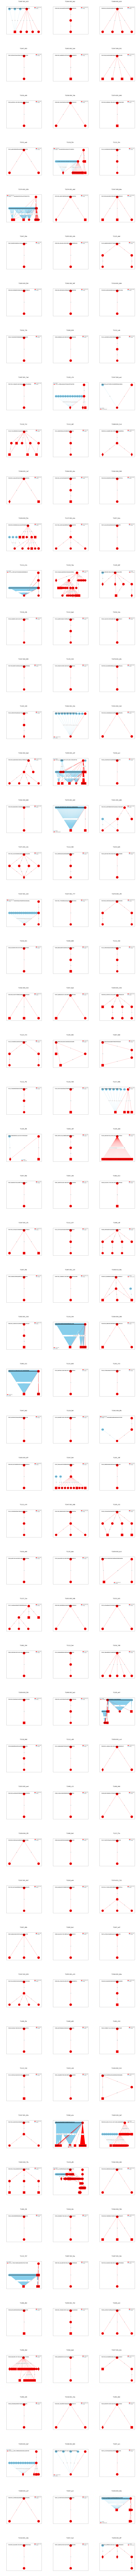

In [3]:
import os as os
import matplotlib.pyplot as plt

def plot_images_in_subplots():
    directory = "./graph_only_benign/"  # the directory where you stored your images
    files = [f for f in os.listdir(directory) if f.endswith('.png')]  # get all .png files in the directory

    n = len(files)  # the number of images
    n_cols = 3  # number of columns in the subplot
    n_rows = n // n_cols + (n % n_cols > 0)  # calculate number of rows needed

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))

    for i, file in tqdm(enumerate(files)):
        img = plt.imread(os.path.join(directory, file))  # read the image
        ax[i // n_cols, i % n_cols].imshow(img)  # plot image
        ax[i // n_cols, i % n_cols].axis('off')  # hide the axis
        label = file.split('_')[0] + '_' + file.split('_')[1][:3]
        ax[i // n_cols, i % n_cols].set_title(label)  # set the file name as title

    plt.tight_layout()
    plt.show()

plot_images_in_subplots()


## Ignore the part below

/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


IndexError: index 9 is out of bounds for axis 0 with size 9

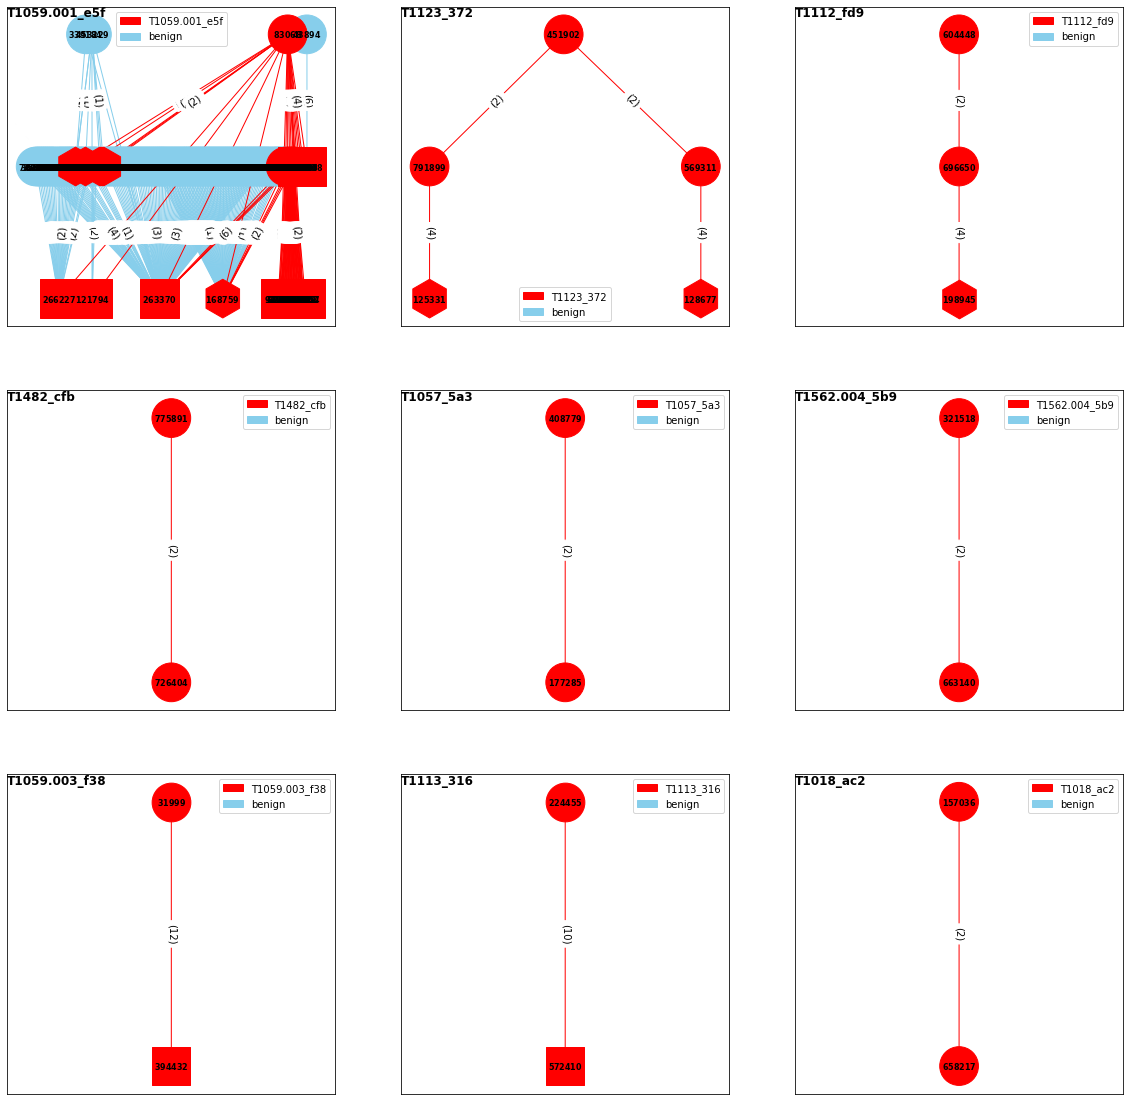

In [28]:
import os
import numpy as np
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.patches as mpatches
from networkx.drawing.nx_agraph import graphviz_layout

def read_data(file_path):
    edges = []
    with open(file_path, "r") as file:
        next(file) # pass the 0th row (titles)

        for line in file:
            source, src_entity, destination, dest_entity, relation, label = line.strip().split(' ')
            # Since we care about benign, just ignore the T1005 and T1046
            if label.startswith('T1005') or label.startswith('T1046'): continue
            edges.append((source, src_entity, destination, dest_entity, relation, label))
            
    # edges is a list contains all the information (each set is stored in a tuple)
    return edges


def get_other_labels_edges(full_edges, related_nodes, target_label):
    other_labels_edges = []
    for edge in full_edges:
        source, src_entity, destination, dest_entity, relation, label = edge
        # only consider the target lable and the benign
        if (label == target_label or label == 'benign') and (source in related_nodes or destination in related_nodes):
            other_labels_edges.append(edge)
    return other_labels_edges


def get_related_nodes(edges, target, is_label=True):
    related_nodes = set()

    for edge in edges:
        source, src_entity, destination, dest_entity, relation, label = edge
        # only consider the target lable and the benign
        if ((is_label and (label == target or label == 'benign')) or (not is_label and (source == target or destination == target))):
            related_nodes.add(source)
            related_nodes.add(destination)

    return related_nodes



def draw_graph(full_edges, target_edges, target_label, title=None, ax=None, figsize=(10, 8), dpi=100):
    related_nodes = get_related_nodes(target_edges, title)  # only consider edges with target_label
    other_labels_edges = get_other_labels_edges(full_edges, related_nodes, title)

    # Separate edges into main graph and others
    main_edges = [edge for edge in target_edges if edge[-1] == target_label]
    other_edges = [edge for edge in target_edges if edge[-1] != target_label] + other_labels_edges

    G = nx.DiGraph()
    edge_labels = {}
    node_colors = {}
    edge_colors = {}
    node_shapes = {
        'process': 'o',    # Circle
        'registry': 'h',   # Hexagon
        'file': 's',       # Square
        'network': 'd'     # Diamond
    }

    # Extract unique labels (e.g., 'T1115_707' from 'T1115_70795de7cbb842edb029b3378c27c008')
    # unique_labels = list(set([label.split('_')[0] + '_' + label.split('_')[1][:3] for _, _, _, _, _, label in other_edges]))  
    unique_labels = list(set([label.split('_')[0] + '_' + label.split('_')[1][:3] if '_' in label else label for _, _, _, _, _, label in other_edges]))  


    # # Convert the target_label to same format as other labels
    target_label_modified = target_label.split('_')[0] + '_' + target_label.split('_')[1][:3]

    # Create a color map with unique colors for each label
    colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)+1))
    red_color = np.array([1, 0, 0, 1])  # Red color
    color_map = {label: color for label, color in zip(unique_labels, colors) if not np.array_equal(color, red_color)}
    color_map[target_label_modified] = red_color  # Assign red color to the target label separately
    color_map['benign'] = 'skyblue'  # Assign black color to the benign label
    # print(color_map)

    # Add other edges
    for source, src_entity, destination, dest_entity, relation, label in other_edges:
        # if label == '0': continue

        # before adding the edge
        src_node_shape = node_shapes.get(src_entity, 'o')  # Use 'o' as the default shape
        dest_node_shape = node_shapes.get(dest_entity, 'o')  # Use 'o' as the default shape
        # print(src_entity, dest_entity) # correct

        # 檢查來源和目標節點是否存在，如果不存在就添加並設定形狀
        if source not in G.nodes:
            G.add_node(source)
            G.nodes[source]['shape'] = src_node_shape

        if destination not in G.nodes:
            G.add_node(destination)
            G.nodes[destination]['shape'] = dest_node_shape
        # print(G.nodes[destination]['shape'])
        

        edge = (source, destination)
        if label != 'benign':
            label_prefix = label.split('_')[0]  # Get the first element after splitting by '_'
            label_prefix_extended = label_prefix + "_" + label.split('_')[1][:3]  # Add "_" and the first three characters after the second '_' to the label_prefix
        else:
            label_prefix_extended = 'benign'

        if edge in G.edges():
            edge_labels[edge] += ", " + relation
        else:
            G.add_edge(source, destination)

            # Check if the edge is a part of the target edges (main graph)
            if label == target_label:
                node_colors[source] = 'red'
                node_colors[destination] = 'red'
                edge_colors[edge] = 'red'
            else:
                node_colors[source] = color_map.get(label_prefix_extended, 'gray')  # Set gray as the default color
                node_colors[destination] = color_map.get(label_prefix_extended, 'gray')  # Set gray as the default color
                edge_colors[edge] = color_map.get(label_prefix_extended, 'black')

            edge_labels[edge] = relation

    # Add main graph edges
    for source, src_entity, destination, dest_entity, relation, label in main_edges:
        if label == 'benign': continue

        # before adding the edge
        src_node_shape = node_shapes.get(src_entity, 'o')  # Use 'o' as the default shape
        dest_node_shape = node_shapes.get(dest_entity, 'o')  # Use 'o' as the default shape
        # print(src_entity, dest_entity) # correct

        # 檢查來源和目標節點是否存在，如果不存在就添加並設定形狀
        if source not in G.nodes:
            G.add_node(source)
            G.nodes[source]['shape'] = src_node_shape

        if destination not in G.nodes:
            G.add_node(destination)
            G.nodes[destination]['shape'] = dest_node_shape
        # print(G.nodes[destination]['shape'])


        edge = (source, destination)
        G.add_edge(source, destination)
        node_colors[source] = 'red'
        node_colors[destination] = 'red'
        edge_colors[edge] = 'red'

        if edge in edge_labels:
            edge_labels[edge] += ", " + relation
        else:
            edge_labels[edge] = relation

    pos = graphviz_layout(G, prog="dot")
    pos = {node: (x, y-0.1) for node, (x, y) in pos.items()}

    # plt.figure(figsize=figsize)

    # Draw nodes with custom label styles
    node_labels = {node: rf"$\bf{{{node}}}$" for node in G.nodes()}
    nx.draw_networkx_edges(G, pos, edge_color=[edge_colors[edge] for edge in G.edges()])

    for shape in node_shapes.values():
        nodelist=[node for node, data in G.nodes(data=True) if data['shape'] == shape]
        colorlist = [node_colors.get(node, 'g') for node in nodelist]

        nx.draw_networkx_nodes(G, pos,
            nodelist=nodelist,
            node_color=colorlist,
            node_size=1500,
            node_shape=shape)


    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight='bold', font_color='black')
    # Draw edges with custom edge labels
    edge_labels = {(source, destination): f"({len(relations.split(','))})" for (source, destination), relations in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    if title:
        output_title = title.split('_')[0] + '_' + title.split('_')[1][:3]
        plt.text(0, 1, output_title, transform=plt.gca().transAxes, fontsize=12, fontweight='bold', verticalalignment='top')

    # for labeling all the label with the corresponding color
    patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
    plt.legend(handles=patches)

    # plt.savefig(file_name + ".png", dpi=dpi)
    # plt.clf()
    plt.sca(ax)
    return ax

def draw_all_graphs(file_path):
    full_edges = read_data(file_path) 
    unique_labels = list(set(edge[5] for edge in full_edges))

    # rows = (len(unique_labels) - 1) // 4 + 1  # calculate number of rows needed
    fig, axs = plt.subplots(3, 3, figsize=(20, 20))

    # 將 axs 轉換為一維陣列，以便我們可以輕鬆地迭代它
    axs = axs.ravel()

    # 假設我們只有四個目標標籤（即unique_labels的長度為4）
    for i, target_label in enumerate(unique_labels):  # 只選取前四個
        if target_label == 'benign': continue

        target_edges = [edge for edge in full_edges if edge[5] == target_label]

        # 在子圖上繪製圖
        # draw_graph(full_edges, target_edges, new_target_label, title=new_target_label, ax=axs[i])
        draw_graph(full_edges, target_edges, target_label, title=target_label, ax=axs[i])

    plt.tight_layout()
    plt.show()


file_path = "../data_new_entity/combined_file_with_entity.txt"
# file_path = "../data_with_entity/test.txt"

draw_all_graphs(file_path)
print("DONE!!")


/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/workdir/home/euni/anaconda3/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/tmp/ipykernel_24649/2324901397.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ip

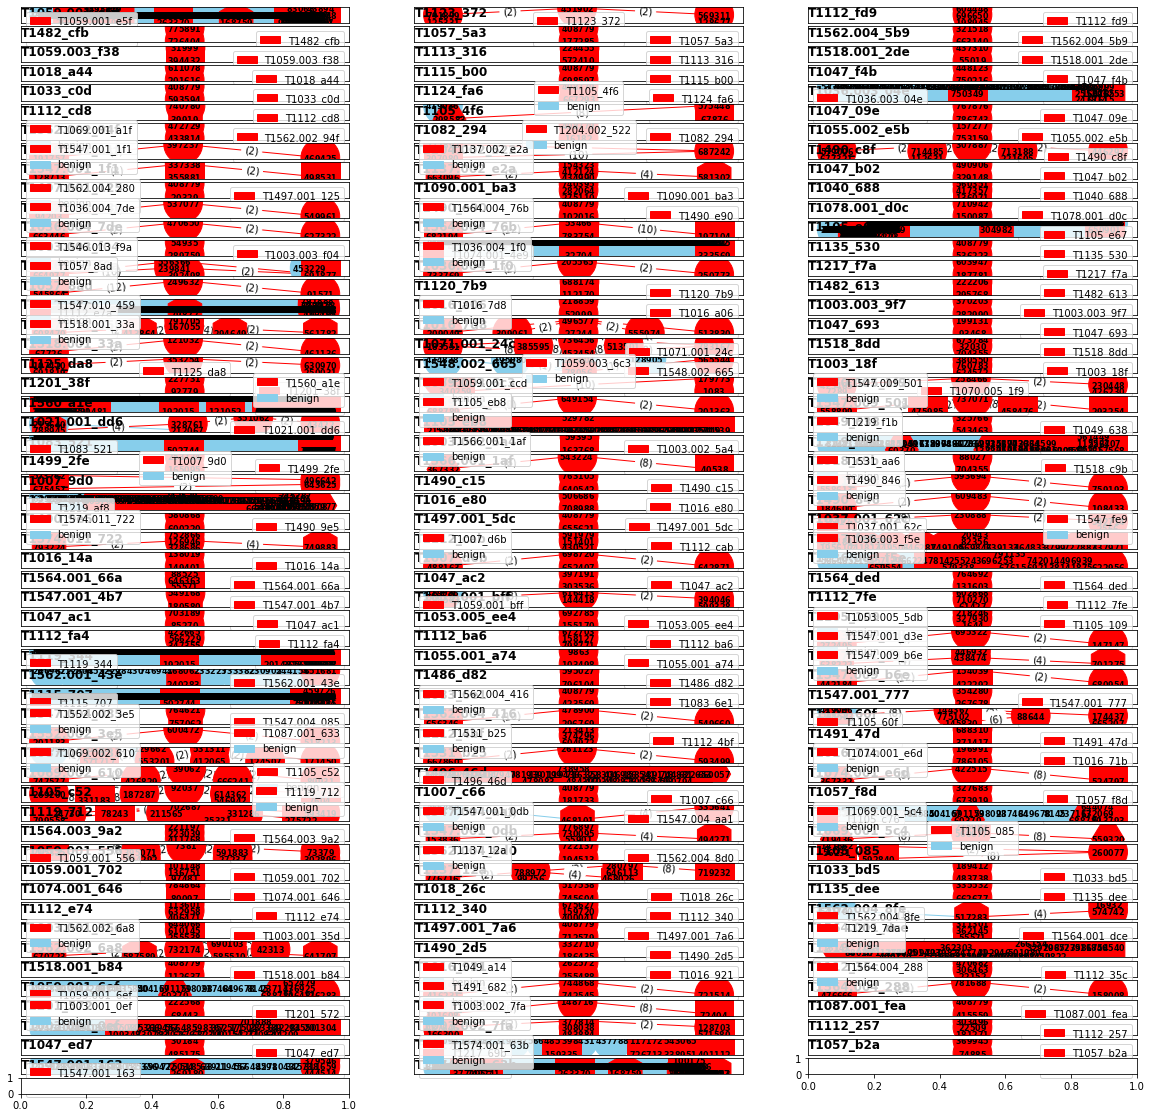

In [29]:
import math

def draw_all_graphs(file_path):
    full_edges = read_data(file_path) 
    unique_labels = list(set(edge[5] for edge in full_edges))

    # calculate the number of rows and columns
    n = len(unique_labels)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(20, 20))

    # Flatten axs to make it easy to iterate over
    axs = axs.ravel()

    for i, target_label in enumerate(unique_labels):
        if target_label == 'benign': continue

        target_edges = [edge for edge in full_edges if edge[5] == target_label]

        # Draw the graph on the subplot
        draw_graph(full_edges, target_edges, target_label, title=target_label, ax=axs[i])

    # Delete the unused subplots
    if n % cols != 0:
        for j in range(n, rows*cols):
            fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


file_path = "../data_new_entity/combined_file_with_entity.txt"
# file_path = "../data_with_entity/test.txt"

draw_all_graphs(file_path)
